In [1]:
import scraper2 as s
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
import seaborn as sns
from yahoo_fin import options
from yahoo_fin.stock_info import *
from yahoo_fin.stock_info import get_data, get_splits
import mibian
import time
m = s.stockMongo()
import indicator as i

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


In [2]:
op = m.stock_data.options_data2.find()
op.count()

C:\Users\ander\AppData\Local\Temp/ipykernel_5168/3622889483.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  op.count()


496851

In [17]:
def dict_parse(df):
    return pd.DataFrame.from_records(df['options'])

In [67]:
start_time = time.time()
op = m.stock_data.options_data2.find({'sym':"MSFT"})
df = pd.DataFrame.from_records(op)
df1 = df.apply(dict_parse, axis=1)
df1 = pd.concat(df1.tolist())
df1.head()
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.30444884300231934 seconds ---


In [71]:
#df1['Last Trade Date'] = df1['Last Trade Date'].str.slice(stop=10)
df1['Last Trade Date'] = pd.to_datetime(df1['Last Trade Date'], format='%Y-%m-%d')
df1 = df1[df1['date']==df1['Last Trade Date']]

In [72]:
df1

,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,date,strike-date,type
0,+2.40%,76.70,76.35,1.95,MSFT220311C00200000,174.51%,83.10,2022-03-08,4,200.0,8,2022-03-08,2022-03-11,call
2,-8.10%,66.45,66.15,-5.70,MSFT220311C00210000,141.11%,64.65,2022-03-08,4,210.0,9,2022-03-08,2022-03-11,call
6,-15.15%,37.95,35.60,-7.80,MSFT220311C00240000,94.68%,43.70,2022-03-08,11,240.0,51,2022-03-08,2022-03-11,call
7,-17.13%,32.90,31.60,-7.51,MSFT220311C00245000,93.65%,36.34,2022-03-08,19,245.0,2,2022-03-08,2022-03-11,call
8,-6.32%,27.85,25.90,-1.97,MSFT220311C00250000,74.80%,29.18,2022-03-08,64,250.0,56,2022-03-08,2022-03-11,call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,+31.58%,106.60,104.10,25.80,MSFT240119P00370000,25.65%,107.50,2022-03-08,107,370.0,133,2022-03-08,2024-01-19,put
60,+3.20%,178.40,175.15,5.48,MSFT240119P00450000,25.36%,176.81,2022-03-08,470,450.0,3,2022-03-08,2024-01-19,put
61,+14.90%,187.75,184.35,24.10,MSFT240119P00460000,25.18%,185.81,2022-03-08,20,460.0,1,2022-03-08,2024-01-19,put
64,+2.46%,225.70,222.15,5.34,MSFT240119P00500000,23.92%,222.40,2022-03-08,15,500.0,10,2022-03-08,2024-01-19,put


In [54]:
dates = options.get_expiration_dates('MSFT')
prices = options.get_options_chain('MSFT', dates[2])
price_calls = pd.DataFrame.from_dict(prices['calls'])
price_calls

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,MSFT220325C00200000,2022-02-17 3:50PM EST,200.0,91.40,75.20,78.25,0.00,-,-,1,75.10%
1,MSFT220325C00220000,2022-02-24 1:47PM EST,220.0,67.46,56.35,58.30,0.00,-,-,1,57.28%
2,MSFT220325C00230000,2022-03-07 11:40AM EST,230.0,52.40,46.40,48.95,0.00,-,5,11,58.47%
3,MSFT220325C00235000,2022-03-07 2:59PM EST,235.0,47.95,42.05,44.15,0.00,-,2,1,55.51%
4,MSFT220325C00240000,2022-03-08 1:03PM EST,240.0,44.38,37.40,39.50,-0.12,-0.27%,20,65,53.55%
5,MSFT220325C00250000,2022-03-08 1:33PM EST,250.0,32.00,28.45,30.65,0.55,+1.75%,42,9,50.64%
6,MSFT220325C00255000,2022-03-08 1:17PM EST,255.0,30.21,24.05,26.30,2.02,+7.17%,5,9,48.23%
7,MSFT220325C00260000,2022-03-08 12:12PM EST,260.0,22.26,20.35,21.50,-3.79,-14.55%,13,11,42.59%
8,MSFT220325C00265000,2022-03-08 2:20PM EST,265.0,17.65,16.70,18.00,-2.75,-13.48%,85,45,42.84%
9,MSFT220325C00270000,2022-03-08 12:43PM EST,270.0,16.58,13.10,14.60,-0.42,-2.47%,125,13,41.93%


In [19]:
start_time = time.time()
apple = m.get_options(tickers[22])
apple['time'] = apple['strike-date'] - apple.index
apple['time'] = apple['time'].dt.total_seconds() / (24 * 60 * 60)
apple['Last Trade Date'] = apple['Last Trade Date'].str.slice(stop=10)
apple['Last Trade Date'] = pd.to_datetime(apple['Last Trade Date'], format='%Y-%m-%d')
apple = apple.reset_index()
strike_dates = apple.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero).columns
#strike_dates[6]
apple2 = apple[apple['strike-date']==strike_dates[0]]
#apple2 = apple2[apple2['date']==apple2['Last Trade Date']]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.21348905563354492 seconds ---


In [20]:
apple2

,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,strike-date,type,time
0,2022-03-07,-,33.30,31.55,0.00,JNJ220318C00140000,61.52%,31.78,2021-12-29,10,140.0,NaN,2022-03-18,call,11.0
1,2022-03-07,-,28.30,26.35,0.00,JNJ220318C00145000,75.73%,26.10,2021-12-29,2,145.0,2.0,2022-03-18,call,11.0
2,2022-03-07,+5.84%,18.50,17.40,1.00,JNJ220318C00155000,56.06%,18.11,2022-01-05,20,155.0,10.0,2022-03-18,call,11.0
3,2022-03-07,+6.93%,14.65,12.95,0.89,JNJ220318C00160000,57.40%,13.73,2022-01-05,87,160.0,60.0,2022-03-18,call,11.0
4,2022-03-07,+7.01%,10.25,8.35,0.63,JNJ220318C00165000,48.93%,9.62,2022-01-05,259,165.0,8.0,2022-03-18,call,11.0
5,2022-03-07,+17.74%,6.55,5.85,0.99,JNJ220318C00170000,43.42%,6.57,2022-01-05,332,170.0,53.0,2022-03-18,call,11.0
6,2022-03-07,+22.08%,3.75,3.40,0.70,JNJ220318C00175000,40.00%,3.87,2022-01-05,309,175.0,94.0,2022-03-18,call,11.0
7,2022-03-07,+26.67%,2.03,1.57,0.44,JNJ220318C00180000,39.16%,2.09,2022-01-05,929,180.0,18.0,2022-03-18,call,11.0
8,2022-03-07,+21.43%,1.00,0.30,0.18,JNJ220318C00185000,38.67%,1.02,2022-01-05,740,185.0,13.0,2022-03-18,call,11.0
9,2022-03-07,-,0.67,0.30,0.00,JNJ220318C00190000,42.53%,0.34,2022-01-04,21,190.0,7.0,2022-03-18,call,11.0


In [3]:
symbols = m.get_symbols()
tickers = []
for sym in symbols:
    tickers.append(sym['sym'])

In [4]:
len(tickers)

58

In [10]:
apple2.tail()

,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,strike-date,type,time
26479,2022-03-06,-,14.10,13.45,0.00,ABT220318P00135000,44.09%,18.47,2022-02-18,82.0,135.0,1.0,2022-03-18,put,12.0
26480,2022-03-06,-,19.45,18.20,0.00,ABT220318P00140000,62.74%,18.30,2022-02-25,1.0,140.0,1.0,2022-03-18,put,12.0
26481,2022-03-06,-,22.90,22.25,0.00,ABT220318P00145000,0.00%,24.25,2022-01-26,0.0,145.0,2.0,2022-03-18,put,12.0
26482,2022-03-06,+0.17%,29.30,28.40,0.05,ABT220318P00150000,63.87%,28.70,2022-03-04,80.0,150.0,40.0,2022-03-18,put,12.0
26483,2022-03-06,-,48.30,46.15,0.00,ABT220318P00170000,0.00%,49.50,2022-01-28,0.0,170.0,1.0,2022-03-18,put,12.0


In [15]:
# set stock ticker symbol
stock_symbol = c[10]
 
# set date range for historical prices
end_time = date.today()
start_time = end_time - timedelta(days=400)
 
# reformat date range
end = end_time.strftime('%Y-%m-%d')
start = start_time.strftime('%Y-%m-%d')
 
# get daily stock prices over date range
prices = get_data(stock_symbol, start, end, 'daily')
#compute daily returns and 20 day moving historical volatility
window_size = 20
prices['returns']=prices['close'].pct_change()
prices['volatility']=prices['returns'].rolling(window_size).std()*(252**0.5)
prices['date'] = prices.index
prices.tail()

,open,high,low,close,adjclose,volume,ticker,returns,volatility,date
2022-03-01,8.51,8.59,7.74,7.96,7.96,1574900,AHT,-0.075494,0.874037,2022-03-01
2022-03-02,7.97,8.42,7.93,8.32,8.32,1045400,AHT,0.045226,0.880576,2022-03-02
2022-03-03,8.31,8.41,7.66,7.85,7.85,1495600,AHT,-0.056490,0.886295,2022-03-03
2022-03-04,7.60,7.68,7.15,7.31,7.31,1432300,AHT,-0.068790,0.909155,2022-03-04
2022-03-04,7.60,7.68,7.15,7.31,7.31,1433908,AHT,0.000000,0.897911,2022-03-04


In [ ]:
o = i.Options(tickers[0])
o.options

In [15]:
tickers[22]

'JNJ'

<AxesSubplot:xlabel='iv', ylabel='return'>

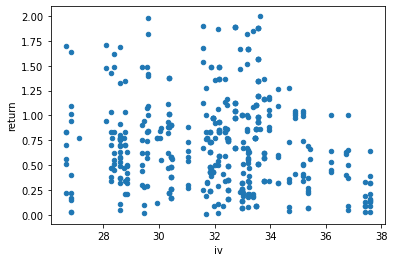

In [25]:
s = o.returns
#s[s.is_won].plot.scatter(x='probability', y='return')
#s.plot.scatter(x='rel_risk', y='return')
s[(s['rel_risk']>0)&(s['return']>0)&(s['return']<2)].plot.scatter(x='iv', y='return')
#o.strikeDates[0].volRange

<AxesSubplot:>

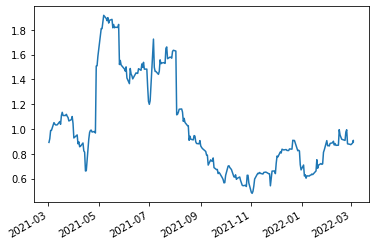

In [17]:
prices.volatility.plot()

In [31]:
m.add("MSFT")

'MSFT' added to the database


In [49]:
len(tickers)

1636

In [29]:
"msft" in tickers

True